In [3]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [21]:
def data_load(dsets, batch_size):
    mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

    mnist_test = dsets.MNIST(root='MNIST_data/',
                            train=False,
                            transform=transforms.ToTensor(),
                            download=True)
    
    # dataset loader
    data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True)

    return data_loader, mnist_train, mnist_test

In [37]:
class LinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim, device):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(input_dim, output_dim, bias = True).to(device)
    
    def forward(self, x):
        x_flatten = x.view(-1, self.input_dim).to(device)
        return self.linear(x_flatten)

In [38]:
def model_setting(input_dim, output_dim, device):

    # 비용 함수와 옵티마이저 정의
    criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
    model = LinearLayer(input_dim, output_dim, device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    return criterion, model, optimizer

In [45]:
def training(training_epochs, data_loader, criterion, model, optimizer, device):
    for one_epoch in range(training_epochs):

        total_batch = len(data_loader)
        avg_cost = 0
        
        for x_train, y_train in data_loader:
            y_train = y_train.to(device)
            model_output = model(x_train)
            cost = criterion(model_output, y_train) ## CrossEntropyLoss

            cost.backward()
            optimizer.step()
            optimizer.zero_grad()

            avg_cost += cost / total_batch

        print(f"Epoch : {one_epoch+1} / {training_epochs}, cost : {avg_cost:.4f}")

    return model 

In [44]:
if __name__ == "__main__":

    # check GPU 
    USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
    device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
    print("다음 기기로 학습합니다:", device)

    # for reproducibility
    random.seed(777)
    torch.manual_seed(777)
    if device == 'cuda': torch.cuda.manual_seed_all(777)

    # model hyperparameters
    training_epochs = 15
    batch_size = 100

    data_loader, mnist_train, mnist_test = data_load(dsets, batch_size)
    input_dim, output_dim = mnist_train.data.shape[-1] * mnist_train.data.shape[-2], 10
    criterion, model, optimizer = model_setting(input_dim, output_dim, device)
    model = training(training_epochs, data_loader, criterion, model, optimizer, device)

다음 기기로 학습합니다: cuda
Epoch : 1 / 15, cost : 0.5352
Epoch : 2 / 15, cost : 0.3596
Epoch : 3 / 15, cost : 0.3313
Epoch : 4 / 15, cost : 0.3164
Epoch : 5 / 15, cost : 0.3071
Epoch : 6 / 15, cost : 0.3005
Epoch : 7 / 15, cost : 0.2949
Epoch : 8 / 15, cost : 0.2910
Epoch : 9 / 15, cost : 0.2871
Epoch : 10 / 15, cost : 0.2845
Epoch : 11 / 15, cost : 0.2819
Epoch : 12 / 15, cost : 0.2795
Epoch : 13 / 15, cost : 0.2776
Epoch : 14 / 15, cost : 0.2759
Epoch : 15 / 15, cost : 0.2744


Accuracy: 0.8883000016212463
Label:  7
Prediction:  7


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


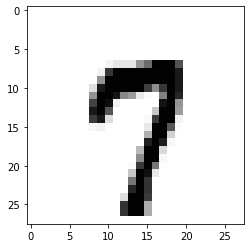

In [48]:
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()